In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

# Some additional libraries which we'll use just
# to produce some visualizations of our training
from libs.utils import montage
from libs import gif
import IPython.display as ipyd
plt.style.use('ggplot')

# Classifying pictures

In [23]:
## reset the default graph 
from tensorflow.python.framework import ops
ops.reset_default_graph()
g=tf.get_default_graph()
[op.name for op in g.get_operations()]

[]

In [24]:
# load data
mnist= input_data.read_data_sets('data/mnist/',one_hot=True) # load data using one hot 

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


label:  [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


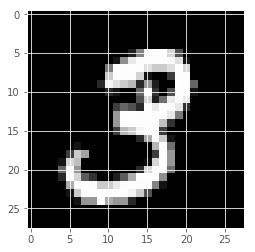

In [25]:
print('label: ',mnist.train.labels[1])
plt.imshow(np.reshape(mnist.train.images[1], (28, 28)), cmap='gray')

#### First let's try fully connected network 

In [26]:
n_input = 28 * 28
n_output = 10
X = tf.placeholder(tf.float32, [None, n_input])         ## input place holder
Y = tf.placeholder(tf.float32, [None, n_output])        ## output place holder 

In [27]:
### linear graph structure 
def linear(x, n_output, name=None, activation=None, reuse=None):
    if len(x.get_shape()) != 2:
        x = flatten(x, reuse=reuse)
    n_input = x.get_shape().as_list()[1]
    with tf.variable_scope(name or "fc", reuse=reuse):
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            dtype=tf.float32,
            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable(
            name='b',
            shape=[n_output],
            dtype=tf.float32,
            initializer=tf.constant_initializer(0.0))
        h = tf.nn.bias_add(
            name='h',
            value=tf.matmul(x, W),
            bias=b)
        if activation:
            h = activation(h)
        return h, W

In [28]:
## create firt layer
Y_pred, W = linear(x=X,n_output=n_output,activation=tf.nn.softmax,name='layer1')
#### softmax is more or less like logistic scaling, turn numbers into a probility 

- we define our cost function slightly differently here
$$H(x) = - \sum{Y_{true} * log(Y_{pred})}$$
- the inituation is that if $Y_{pred}$ will be a probability for 10 classes, if the correct prediceted label get higher weight, the product will be higher, and the H(x) will be lower. we are tyring to find lowest H(x)

In [29]:
# We add 1e-12 because the log is undefined at 0.
cross_entropy = -tf.reduce_sum(Y * tf.log(Y_pred + 1e-12))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)
predicted_y = tf.argmax(Y_pred,1)  ## Y_pred, each row is an out put,is a row vector, so use asix =1 
actual_y = tf.argmax(Y,1)          ## Y is also a row vector 
# calculate accuracy
correct_prediction = tf.equal(predicted_y, actual_y)   ## two vector, see if they equal
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

##### Train the network 

In [30]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
# Now actually do some training:
batch_size = 50
n_epochs = 5
n_batch = mnist.train.num_examples//batch_size 
for epoch_i in range(n_epochs):
    for i in range(n_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size) 
        sess.run(optimizer, feed_dict={X: batch_xs,Y: batch_ys})
    valid = mnist.validation
    print(sess.run(accuracy,feed_dict={X: valid.images,Y: valid.labels}))

# Print final test accuracy:
test = mnist.test
print(sess.run(accuracy,
               feed_dict={
                   X: test.images,
                   Y: test.labels
               }))

0.9098
0.9192
0.9236
0.926
0.9268
0.9246


In [31]:
# We first get the graph that we used to compute the network
g = tf.get_default_graph()
# And can inspect everything inside of it
[op.name for op in g.get_operations()]

['Placeholder',
 'Placeholder_1',
 'layer1/W/Initializer/random_uniform/shape',
 'layer1/W/Initializer/random_uniform/min',
 'layer1/W/Initializer/random_uniform/max',
 'layer1/W/Initializer/random_uniform/RandomUniform',
 'layer1/W/Initializer/random_uniform/sub',
 'layer1/W/Initializer/random_uniform/mul',
 'layer1/W/Initializer/random_uniform',
 'layer1/W',
 'layer1/W/Assign',
 'layer1/W/read',
 'layer1/b/Initializer/Const',
 'layer1/b',
 'layer1/b/Assign',
 'layer1/b/read',
 'layer1/MatMul',
 'layer1/h',
 'layer1/Softmax',
 'add/y',
 'add',
 'Log',
 'mul',
 'Const',
 'Sum',
 'Neg',
 'gradients/Shape',
 'gradients/Const',
 'gradients/Fill',
 'gradients/Neg_grad/Neg',
 'gradients/Sum_grad/Reshape/shape',
 'gradients/Sum_grad/Reshape',
 'gradients/Sum_grad/Shape',
 'gradients/Sum_grad/Tile',
 'gradients/mul_grad/Shape',
 'gradients/mul_grad/Shape_1',
 'gradients/mul_grad/BroadcastGradientArgs',
 'gradients/mul_grad/mul',
 'gradients/mul_grad/Sum',
 'gradients/mul_grad/Reshape',
 'grad

#### We can also try to take a look at the weights 

Looking at the names of the operations, we see there is one linear/W. But this is the tf.Operation. Not the tf.Tensor. The tensor is the result of the operation. To get the result of the operation, we simply add ":0" to the name of the operation:

(784, 10)


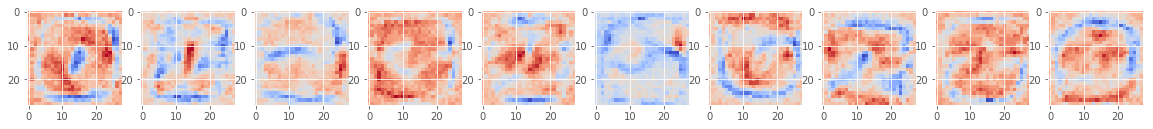

In [32]:
W = g.get_tensor_by_name('layer1/W:0')
W_arr = np.array(W.eval(session=sess))
print(W_arr.shape)
fig, ax = plt.subplots(1, 10, figsize=(20, 3))
for col_i in range(10):
    ax[col_i].imshow(W_arr[:, col_i].reshape((28, 28)), cmap='coolwarm')

##### So, warmer pixels mean heigher wieghts. So when the input picture has heigher values in those pexels, it is more likely to be in a particular number. We can almost see the shape of the number in these pictures. 

## Use Convolutional Networks
- using 1 layer first

In [38]:
## reset the default graph 
from tensorflow.python.framework import ops
ops.reset_default_graph()
g=tf.get_default_graph()
[op.name for op in g.get_operations()]

[]

In [39]:
mnist= input_data.read_data_sets('data/mnist/',one_hot=True)
X = tf.placeholder(tf.float32, [None, n_input])         ## input place holder
Y = tf.placeholder(tf.float32, [None, n_output])        ## output place holder 

# to apply convolution filter, transfrom tensor to 4d 
X_tensor = tf.reshape(X, [-1, 28, 28, 1])            ## again, -1 mean a constanst dimention, same as input number of rows 

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


In [40]:
##################################
## set up first layer ###
##################################

filter_size = 5             ## how big the window will be, it is 5 by 5 pixel here 
n_filters_in = 1            ## because the color is grey scale, so the chanel is 1
n_filters_out = 32          ## use 32 filters
W_1 = tf.get_variable(
    name='W',
    shape=[filter_size, filter_size, n_filters_in, n_filters_out], ## 5,5,1,32
    initializer=tf.random_normal_initializer())
## set bias variable, it is always the size of n_filters_out
b_1 = tf.get_variable(
    name='b',
    shape=[n_filters_out],
    initializer=tf.constant_initializer())
h_1 = tf.nn.relu(
    tf.nn.bias_add(
        tf.nn.conv2d(input=X_tensor,
                     filter=W_1,
                     strides=[1, 2, 2, 1],  ## 2 by 2, will shink size
                     padding='SAME'),
        b_1))

In [43]:
##########################
## set up second layer ###
##########################

n_filters_in = 32
n_filters_out = 64
W_2 = tf.get_variable(
    name='W2',
    shape=[filter_size, filter_size, n_filters_in, n_filters_out],
    initializer=tf.random_normal_initializer())
b_2 = tf.get_variable(
    name='b2',
    shape=[n_filters_out],
    initializer=tf.constant_initializer())
h_2 = tf.nn.relu(
    tf.nn.bias_add(
        tf.nn.conv2d(input=h_1,
                 filter=W_2,
                 strides=[1, 2, 2, 1],
                 padding='SAME'),
        b_2))

In [45]:
# We'll now reshape so we can connect to a fully-connected/linear layer:
h_2_flat = tf.reshape(h_2, [-1, 7 * 7 * n_filters_out])

# NOTE: This uses a slightly different version of the linear function than the lecture!
h_3, W = linear(h_2_flat, 128, activation=tf.nn.relu, name='fc_1')
# out put layer 
Y_pred, W = linear(h_3, n_output, activation=tf.nn.softmax, name='fc_2')   ## out put in n by 10 matrix

<img src = 'pic/Convolution_classification.PNG',height = 80%, wieght = 70%>

#### Training the Network

In [46]:
cross_entropy = -tf.reduce_sum(Y * tf.log(Y_pred + 1e-12))
optimizer = tf.train.AdamOptimizer().minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(Y_pred, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))


sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Now actually do some training:
batch_size = 50
n_epochs = 5
n_batch = mnist.train.num_examples//batch_size 
for epoch_i in range(n_epochs):
    for i in range(n_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size) 
        sess.run(optimizer, feed_dict={X: batch_xs,Y: batch_ys})
    valid = mnist.validation
    print(sess.run(accuracy,feed_dict={X: valid.images,Y: valid.labels}))

# Print final test accuracy:
test = mnist.test
print(sess.run(accuracy,
               feed_dict={
                   X: test.images,
                   Y: test.labels
))

0.7296
0.9704
0.9736
0.9762
0.9724
0.9721


#### Now let's try to predict 

predicted value:  [4]


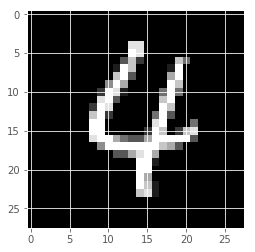

In [89]:
### now, try to predict one 
index = 110
y_p = sess.run(Y_pred,feed_dict={X: mnist.test.images[index-1:index]})   ## X, need two dimentions,simply array won't work
y_p = sess.run(tf.argmax(y_p, 1))
print('predicted value: ', y_p)
plt.imshow(np.reshape(mnist.test.images[index-1], (28, 28)), cmap='gray')

#### Inspecting the Trained Network

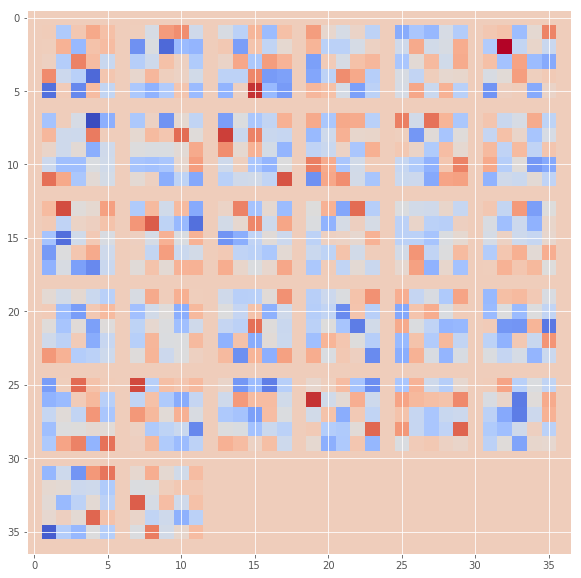

In [47]:
from libs.utils import montage_filters
W1 = sess.run(W_1)
plt.figure(figsize=(10, 10))
plt.imshow(montage_filters(W1), cmap='coolwarm', interpolation='nearest')

##### This is actually very difficult to inteprate, we will come back to this later 

### Saving/Loading Models

- need to work on this part later 
https://github.com/pkmital/CADL/blob/master/session-3/lecture-3.ipynb